# Comparing results from different machine learning algorithms

#### Import packages and data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as mse
import scipy.stats as st

In [2]:
# === Importing data ===
# Predictions from the algorithms
path = "/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/Machine Learning Algorithms/Comparison/datasets"
excel_files = os.listdir(path)
excel_files = [excel_file for excel_file in excel_files if excel_file.split(".")[-1] == "xlsx" ]
excel_files.remove("Styringsrenter_sammensatt_visualisering.xlsx")
excel_files.remove("folio_rate.xlsx")

names_models = list()
df = pd.DataFrame()
for excel_file in excel_files:
    name = "_".join(excel_file.split(".")[:-1][0].split("_")[:-1])
    names_models.append(name)
    cols = ["Date"] + [name + "_" + str(n) for n in np.arange(0, 5)]
    imported_file = pd.read_excel("./datasets/" + excel_file, index_col = [0], names = cols)
    df = pd.concat([df, imported_file], axis = 1)

df.dropna(how = "all", inplace = True)

# Norges Bank's predictions
norges_bank = pd.read_excel("./datasets/Styringsrenter_sammensatt_visualisering.xlsx", index_col = [0])

# The folio rate
#folio_rate = pd.read_excel("./datasets/folio_rate.xlsx", index_col = [0])
folio_rate = pd.read_excel("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/Data/base_models_predictions_pdates.xlsx", index_col = [0])
folio_rate.columns = ["folio_rate"]

# Concatenate
df_full = pd.concat([folio_rate.rename(columns = {"NO_folio_publication_date":"folio_rate"}), df], axis = 1, join = "inner")
df = pd.concat([norges_bank.loc[df_full.index[0]:, :], df_full], axis = 1, join = "outer")

# Creating empty dataframe with dates between start and end of data
from datetime import date, timedelta

sdate = date(2016, 12, 13)   # start date
edate = date(2020, 12, 31)   # end date

delta = edate - sdate       # as timedelta

datelist = list()
for i in range(delta.days + 1):
    day = sdate + timedelta(days=i)
    datelist.append(day)
empty_dates = pd.DataFrame(index = datelist)

# === Fill empty predictions ===
# Extract Norges Bank's predictions and dates
nb = df.iloc[:, :5]
nb_dates = list(norges_bank.index) + [norges_bank.index[-1] + timedelta(days = i) for i in [30 * 3, 30 * 6, 30 * 9, 30 * 12]]
nb_dates = pd.Series(index = nb_dates, dtype = "object")

# Loop through each row and fill
new = pd.DataFrame(index = df.index, columns = nb.columns)
for n, row in enumerate(nb.loc[:"2020-03-18", :].index):
    row = nb.loc[row, :]
    if row.isna().any():
        row_prior = nb.iloc[n - 1,:]
        act_times = [row_prior.name + timedelta(days = i) for i in [0, 30 * 3, 30 * 6, 30 * 9, 30 * 12]]
        row_prior.index = act_times
        x = pd.concat([empty_dates, row_prior], axis = 1, join = "outer").ffill()
        start_date = row.name
        date_preds = df.loc[start_date:, :].index[:5]
        new.loc[start_date] = x.loc[date_preds, :].T.values
    else:
        act_times = [row.name + timedelta(days = i) for i in [0, 30 * 3, 30 * 6, 30 * 9, 30 * 12]]
        row.index = act_times
        x = pd.concat([empty_dates, row], axis = 1, join = "outer").ffill()
        start_date = row.name
        date_preds = df.loc[start_date:, :].index[:5]
        new.loc[start_date] = x.loc[date_preds, :].T.values

# Fill the observation for 2020-03-11
row = nb.loc["2019-12-17"]
act_times = [row.name + timedelta(days = i) for i in [0, 30 * 3, 30 * 6, 30 * 9, 30 * 12]]
row.index = act_times
x = pd.concat([empty_dates, row], axis = 1, join = "outer").ffill()
start_date = "2020-03-11"
date_preds = df.loc[start_date:, :].index[:5]
new.loc[start_date] = x.loc[date_preds, :].T.values

df.iloc[:, :5] = new.astype("float64")
df.dropna(inplace = True)

In [36]:
# Indicate font
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size":15
})

#### Visualization

In [23]:
from collections import defaultdict

# Slice plotting dataframe
slice_ = "2019-01-22"
dates = df.loc[slice_:, :].iloc[:4 + 1, :].index
df_copy = df.copy()
df_copy.dropna(axis = 0, how = "all", inplace = True)

# Extract quarterly predictions
predictions = pd.DataFrame(df.loc[dates, "folio_rate"])
for n, column in enumerate(["nb"] + names_models):
    cols = [col for col in df_copy.columns if column in col]
    predictions.loc[:, column] = df_copy.loc[slice_, cols].values
    
# Indicate colors for models
colors_models = {
    "Folio Rate":"black",
    "Actual":"black",
    "Norges Bank":"skyblue",
    "Ensemble Learner":"navy",
    "Elastic Net":"slategrey",
    "LSTM":"darkred",
    "CNN":"darkcyan",
    "Decision Tree":"green"
}
# Mapping model names to parameters
# Indicate mapping of model names
mapping = {
    "nb":"Norges Bank",
    "ensemble":"Ensemble Learner",
    "LSTM":"LSTM",
    "CNN":"CNN",
    "elastic_net":"Elastic Net",
    "DT":"Decision Tree",
    "folio_rate":"Actual",
    "NO_folio_publication_date":"Actual"
}
linestyle_models = {
    "Folio Rate":"-",
    "Actual":"-",
    "Norges Bank":"--",
    "Ensemble Learner":"--",
    "Elastic Net":"--",
    "LSTM":"--",
    "CNN":"--",
    "Decision Tree":"--"
}
linewidth_models = {
    "Folio Rate":1.5,
    "Actual":1.5,
    "Norges Bank":1,
    "Ensemble Learner":1,
    "Elastic Net":1,
    "LSTM":1,
    "CNN":1,
    "Decision Tree":1
}

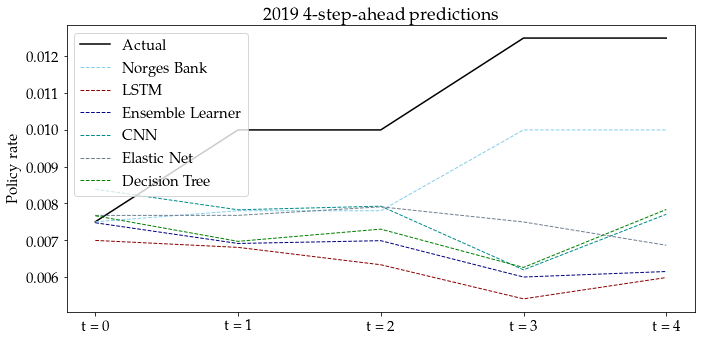

In [38]:
x_axis = ["t = {}".format(period) for period in range(5)]
n_models = len(names_models) + 1
plotting_parameters = {
    "names":mapping,
    "alpha":[1] + [0.5] * n_models,
    "color":colors_models,
    "linewidth": linewidth_models,
    "linestyle": linestyle_models
}

plt.figure(figsize = (10, 5))
for n, fig in enumerate(predictions.columns):
    name = mapping[fig]
    plt.plot(
        x_axis,
        predictions.loc[:, fig],
        label = name,
        color = plotting_parameters["color"][name],
        #alpha = plotting_parameters["alpha"][n],
        linewidth = plotting_parameters["linewidth"][name],
        linestyle = plotting_parameters["linestyle"][name]
            )
plt.legend(loc = "upper left")
plt.title("2019 4-step-ahead predictions")
plt.ylabel("Policy rate")
#plt.ylim(bottom = 0.00, top = 0.02)

plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/fourstep.pgf")

In [39]:
folio_rates = folio_rate.copy().rename(columns = {"NO_folio_publication_date":"folio_rate_0"})
for i in range(1, 5):
    folio_rates.loc[:, "folio_rate_{}".format(i)] = folio_rate.shift(-i).values

folio_rates.fillna(0, inplace = True)

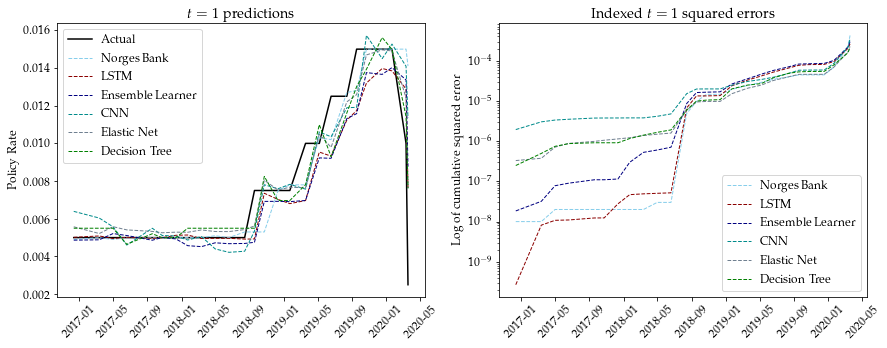

In [41]:
# === Plotting 1-Quarter Predictions ===
plt.rcParams.update({
    "font.size":15
})


q_1 = pd.DataFrame(df_copy.folio_rate)

for column in df_copy.columns:
    base_name = "_".join(column.split("_")[:-1])
    if column.split("_")[-1] == str(1):
        q_1.loc[:, base_name] = df_copy.loc[:, column]

plt.figure(figsize = (12.5, 5))

# === Indexed squared errors ===
# Creating dataframe with errors
errors = pd.DataFrame(index = df_copy.index)
for model in ["nb"] + names_models:
    df_ex_folio = df_copy.drop(columns = "folio_rate")
    cols = [col for col in df_ex_folio.columns if model in col]
    model_excerpt = df_ex_folio.loc[:, cols]
    model_error = model_excerpt.subtract(folio_rates.loc[model_excerpt.index, :].values, axis = 1)
    errors = pd.concat([errors, model_error], axis = 1)

squared_errors = errors ** 2
cols = ["_".join(x.split("_1"[:-1])) for x in squared_errors.columns if x != "folio_rate" and x.split("_")[-1] == "1"]
names = ["_".join(x.split("_")[:-1]) for x in cols]

# === Plotting ===
plt.rcParams.update({'font.size': 12})

plt.subplot2grid(shape = (1, 2), loc = (0, 1))
for n, fig in enumerate(cols):
    cumprod_ = np.log(np.cumprod(squared_errors.loc[:, fig] + 1))
    name = plotting_parameters["names"][names[n]]
    plt.plot(
        cumprod_,
        label = name,
        color = colors_models[name],
        linewidth = plotting_parameters["linewidth"][name],
        linestyle = plotting_parameters["linestyle"][name]
        )
#plt.legend(bbox_to_anchor=(1.01, 1))
plt.legend()
plt.title(r"Indexed $t = 1$ squared errors")
plt.ylabel("Log of cumulative squared error")
plt.yscale("log")
plt.xticks(rotation = 45)

# One-quarter predictions
plt.subplot2grid(shape = (1, 2), loc = (0, 0))
names_ = ["folio_rate"] + names
for n, column in enumerate(q_1.columns):
    name = plotting_parameters["names"][names_[n]]
    plt.plot(
        q_1.loc[:, column],
        label = name,
        color = colors_models[name],
        linewidth = plotting_parameters["linewidth"][name],
        linestyle = plotting_parameters["linestyle"][name]
        )
#plt.legend(bbox_to_anchor=(1.01, 1))
plt.legend()
plt.title(r"$t = 1$ predictions")
plt.ylabel("Policy Rate")
plt.xticks(rotation = 45)

plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/t1.pgf")

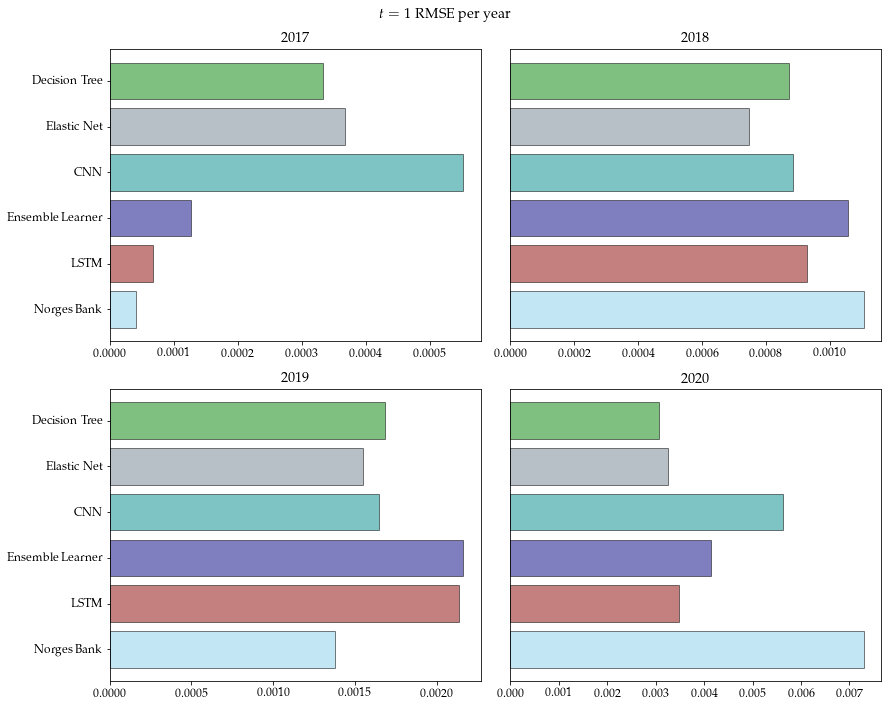

In [43]:
# 1-Quarter predictions per year
q_1_se = q_1.iloc[1:, 1:].subtract(q_1.iloc[1:, 0], axis = 0) ** 2
q_1_rmse = np.sqrt(q_1_se.dropna().resample("Y").mean())
q_1_rmse.index = 2017, 2018, 2019, 2020
q_1_rmse.columns = ["Norges Bank", "LSTM", "Ensemble Learner", "CNN", "Elastic Net", "Decision Tree"]

cols = [0, 1, 0, 1]
rows = [0, 0, 1, 1]

plt.figure(figsize = (12.5, 10))
for n, year in enumerate(q_1_rmse.index):
    plt.subplot2grid(shape = (2, 2), loc = (rows[n], cols[n]))
    y = q_1_rmse.columns
    width = q_1_rmse.loc[year, :]
    plt.barh(
        y = y,
        width = width,
        color = [colors_models[item] for item in q_1_rmse.columns],
        edgecolor = "black",
        alpha = 0.5
            )
    if n == 1 or n == 3:
        plt.yticks([])
    plt.title("{}".format(year))
    #plt.box(on = False)

plt.suptitle(r"$t = 1$ RMSE per year")
plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/rmseyear.pgf")

#### Summary tables

In [44]:
# === Descriptive summary of all models ===
summary = pd.DataFrame()
errors = pd.DataFrame()

for n, model in enumerate(["nb"] + names_models):
    cols = [n for n, column in enumerate(df_copy.columns) if model in "_".join(column.split("_")[:-1])]
    model_pred = df_copy.iloc[:, cols].dropna()
    errors_mdl = model_pred.subtract(folio_rates.loc[model_pred.index, :].values, axis = 1)
    errors = pd.concat([errors, errors_mdl], axis = 1)
    for quarter in range(len(model_pred.columns)):
        pred = model_pred.iloc[:, quarter]
        pred_index = pred.index
        summary.loc[mapping[model], "t = " + str(quarter)] = mse(folio_rates.loc[pred_index, folio_rates.columns[quarter]], pred, squared = False)
        
for quarter in summary.columns:
    bm = summary.loc[:, quarter].idxmin()
    if bm =="Norges Bank":
        next_best_value = min(summary.loc[:, quarter].drop(index = "Norges Bank"))
        next_best_model = summary.loc[summary.loc[:, quarter] == next_best_value, quarter].index.item()
        diff = round(np.log(summary.loc["Norges Bank", quarter] / summary.loc[next_best_model, quarter]), 4)
        summary.loc["Best Model", quarter] = bm
    else:
        summary.loc["Best Model", quarter] = bm
        diff = round(np.log(summary.loc["Norges Bank", quarter] / summary.loc[summary.loc["Best Model", quarter], quarter]), 4)
    summary.loc["Difference", quarter] = diff
    
#print(summary)
print(summary.to_latex())

\begin{tabular}{llllll}
\toprule
{} &          t = 0 &          t = 1 &          t = 2 &     t = 3 &          t = 4 \\
\midrule
Norges Bank      &       0.002768 &       0.004041 &       0.004607 &  0.005562 &       0.006305 \\
LSTM             &       0.002023 &       0.003177 &       0.004563 &  0.005084 &       0.005873 \\
Ensemble Learner &       0.001849 &       0.003379 &       0.004681 &  0.005547 &       0.006003 \\
CNN              &       0.002521 &       0.003667 &       0.004581 &  0.004971 &       0.006239 \\
Elastic Net      &       0.001725 &       0.002949 &       0.004188 &  0.005076 &       0.006166 \\
Decision Tree    &       0.001592 &       0.002887 &       0.004034 &  0.005098 &        0.00565 \\
Best Model       &  Decision Tree &  Decision Tree &  Decision Tree &       CNN &  Decision Tree \\
Difference       &         0.5531 &         0.3362 &         0.1326 &    0.1124 &         0.1096 \\
\bottomrule
\end{tabular}



Decision Tree       0.003852
Elastic Net         0.004021
LSTM                0.004144
Ensemble Learner    0.004292
CNN                 0.004396
Norges Bank         0.004657
dtype: float64

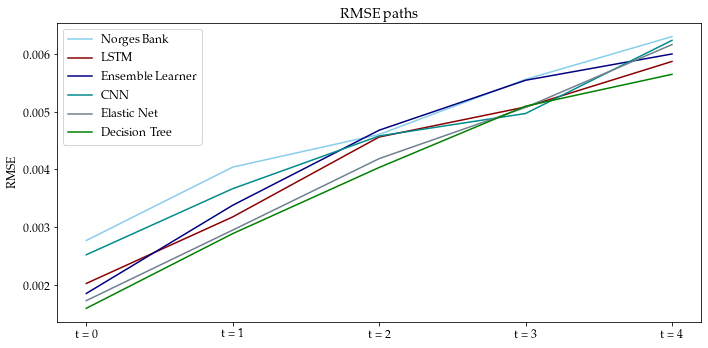

In [46]:
RMSE_path = summary.iloc[:6, :]
plt.figure(figsize = (10, 5))
for model in RMSE_path.index:
    clr = colors_models[model]
    plt.plot(RMSE_path.loc[model, :], color = clr, label = model)

plt.legend()
plt.ylabel("RMSE")
plt.title("RMSE paths")
plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/rmsepaths.pgf")

# === Average RMSE across quarters ===
summary.iloc[:-2, :].mean(axis = 1).sort_values()

In [11]:
wins = pd.DataFrame()
for base_var in mapping.keys():
    if base_var == "folio_rate":
        pass
    else:
        der_var = [x for x in df_copy.columns if base_var in x]
        exc = df_copy.copy().loc[:, der_var]
        for n, var in enumerate(exc.columns):
            exc.loc[:, var] = abs(exc.loc[:, var] - df_copy.folio_rate.shift(n))
    wins = pd.concat([wins, exc], axis = 1)    

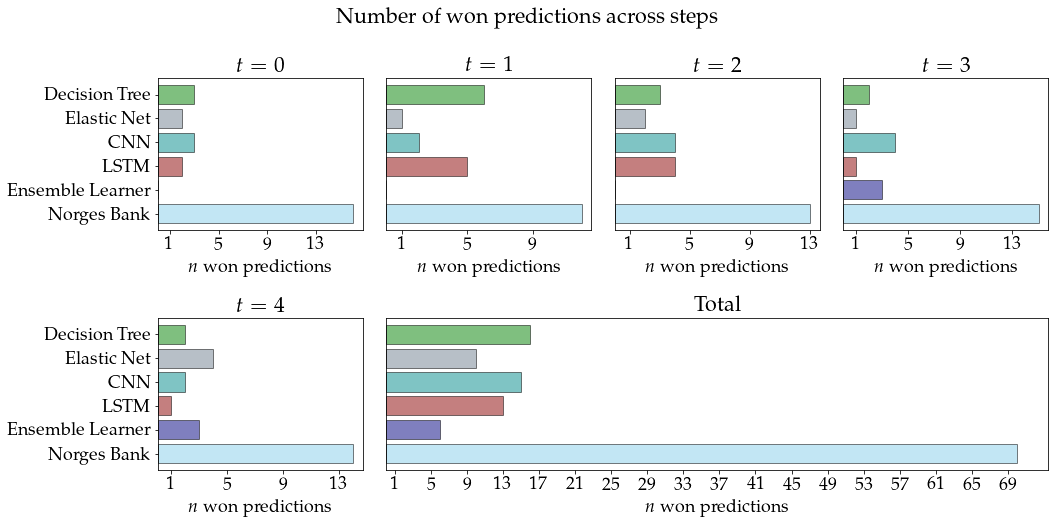

In [49]:
# === Number of won predictions ===
#absolute_error = abs(df_copy.drop(columns = ["folio_rate"]).subtract(df_copy.folio_rate, axis = 0))
#absolute_error = wins.copy()
plt.rcParams.update({
    "font.size":18
})

absolute_error = abs(errors)
dic_wins = dict()
model_names_pretty = [mapping[x] for x in mapping.keys() if x != "folio_rate" and x != "NO_folio_publication_date"]
columns_wins = ["t = {} wins".format(quarter) for quarter in range(5)]
empty_df_wins = pd.DataFrame(np.zeros(6), index = model_names_pretty)
total_wins = empty_df_wins.copy()
for quarter in range(5):
    cols = [column for column in absolute_error.columns if column.split("_")[-1] == str(quarter)]
    temp_df = absolute_error.loc[:, cols]
    n_wins = [mapping["_".join(model.split("_")[:-1])] for model in temp_df.idxmin(axis = 1).values if model == model]
    _ = empty_df_wins.copy()
    _.columns = [columns_wins[quarter]]
    for index in _.index:
        _.loc[index] = n_wins.count(index)
    dic_wins[quarter] = _
    total_wins = pd.concat([total_wins, _], axis = 1)

total_wins = pd.DataFrame(total_wins.sum(axis = 1).rename("total wins"))
dic_wins[5] = total_wins

shape = (2, 4)
rows = [0] * 4 + [1] * 2
columns = [0, 1, 2, 3, 0, 1]

plt.figure(figsize = (15, 7.5))
for quarter in range(6):
    y = np.array(dic_wins[quarter].index.values).reshape(-1)
    width = np.array(dic_wins[quarter].values).reshape(-1)
    if quarter == 5:
        plt.subplot2grid(shape = shape, loc = (rows[quarter], columns[quarter]), rowspan = 1, colspan = 3)
        plt.title("Total")
    else:
        plt.subplot2grid(shape = shape, loc = (rows[quarter], columns[quarter]))
        plt.title(r"$t = {}$".format(quarter))
    plt.barh(y = y, width = width, color = [colors_models[item] for item in dic_wins[quarter].index], edgecolor = "black", alpha = 0.5)
    if quarter == 0 or quarter == 4:
        pass
    else:
        plt.yticks([])
    plt.xticks(np.arange(1, dic_wins[quarter].max().values[0] + 1, 4))
    plt.xlabel(r"$n$ won predictions")

plt.suptitle("Number of won predictions across steps")
plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/wins.pgf")

<ipython-input-55-1c52ebb33649>:15: RuntimeWarning: invalid value encountered in sqrt
  confidence.loc["Lower CI", model_names_pretty[i]] = np.sqrt(confidence_interval[0])


\begin{tabular}{lrrrrrr}
\toprule
{} &  Norges Bank &  Ensemble Learner &       LSTM &        CNN &  Elastic Net &  Decision Tree \\
\midrule
Mean     &     0.004041 &          0.003177 &   0.003379 &   0.003667 &     0.002949 &       0.002887 \\
Lower CI &          NaN &          0.000852 &   0.000840 &        NaN &          NaN &       0.000842 \\
Upper CI &     0.005980 &          0.004411 &   0.004705 &   0.005263 &     0.004182 &       0.003995 \\
n        &    26.000000 &         26.000000 &  26.000000 &  26.000000 &    26.000000 &      26.000000 \\
\bottomrule
\end{tabular}



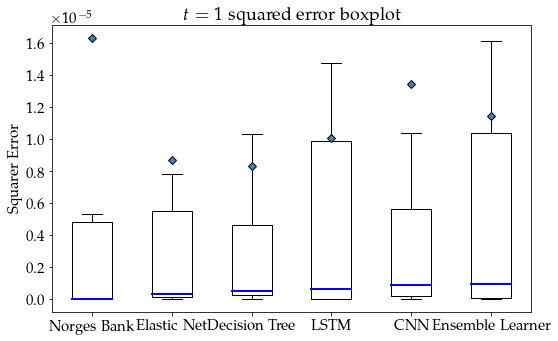

In [55]:
# === Confidence interval of errors ===
plt.rcParams.update({
    "font.size":15
})

squared_errors = errors ** 2
confidence = pd.DataFrame()
df_boxplots = pd.DataFrame()

for i, model in enumerate(["nb"] + names_models):
    squared_error = squared_errors.loc[:, model + "_1"].dropna()
    df_boxplots[mapping[model]] = squared_error
    confidence_interval = np.array(st.t.interval(alpha = 0.95, df = len(squared_error) - 1, loc = np.mean(squared_error), scale = st.sem(squared_error)))
    confidence.loc["Mean", model_names_pretty[i]] = np.sqrt(np.mean(squared_error))
    confidence.loc["Lower CI", model_names_pretty[i]] = np.sqrt(confidence_interval[0])
    confidence.loc["Upper CI", model_names_pretty[i]] = np.sqrt(confidence_interval[1])
    confidence.loc["n", model_names_pretty[i]] = int(len(squared_error))


#confidence.replace(np.nan, 0, inplace = True)    
# === Box plot ===
#df_boxplots.drop(columns = ["CNN", "LSTM", "DT"], inplace = True)
plt.figure(figsize = (15, 5))

plt.subplot2grid(shape = (1, 2), loc = (0, 0))
medianprops = {"color":"blue", "linewidth":2}
meanprops = {"marker":"D", "markeredgecolor":"black", "markerfacecolor":"steelblue"}
sorted_values_boxplot = df_boxplots.loc[:, df_boxplots.median().sort_values().index]
box = plt.boxplot(sorted_values_boxplot, showfliers = False, showmeans = True, meanprops = meanprops, medianprops = medianprops)
plt.xticks(ticks = np.arange(1, sorted_values_boxplot.shape[1] + 1), labels = sorted_values_boxplot.columns.values)
plt.ylabel("Squarer Error")
plt.title(r"$t = 1$ squared error boxplot")

plt.tight_layout()

#print(confidence)
print(confidence.to_latex())
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/bp.pgf")

In [15]:
start = "2020-03-11"
dates = folio_rates.loc[start:].index[:5]
x_axis = ["t = {}".format(period) for period in range(5)]

# Extract time-step predictions
predictions = pd.DataFrame(folio_rate.loc[dates])
for n, column in enumerate(["nb"] + names_models):
    cols = [col for col in df_copy.columns if column in col]
    predictions.loc[:, column] = df_copy.loc[start, cols].values
    
#print(predictions)

            folio_rate      nb      LSTM  ensemble       CNN  elastic_net  \
2020-03-11      0.0100  0.0150  0.015246  0.014236  0.016574     0.013650   
2020-03-18      0.0025  0.0150  0.012886  0.013369  0.014093     0.012405   
2020-05-05      0.0000  0.0150  0.014206  0.013971  0.015712     0.011599   
2020-06-16      0.0000  0.0158  0.009763  0.013510  0.011238     0.010481   
2020-08-18      0.0000  0.0158  0.009856  0.011784  0.012036     0.012260   

                  DT  
2020-03-11  0.012644  
2020-03-18  0.011422  
2020-05-05  0.010334  
2020-06-16  0.009700  
2020-08-18  0.009160  


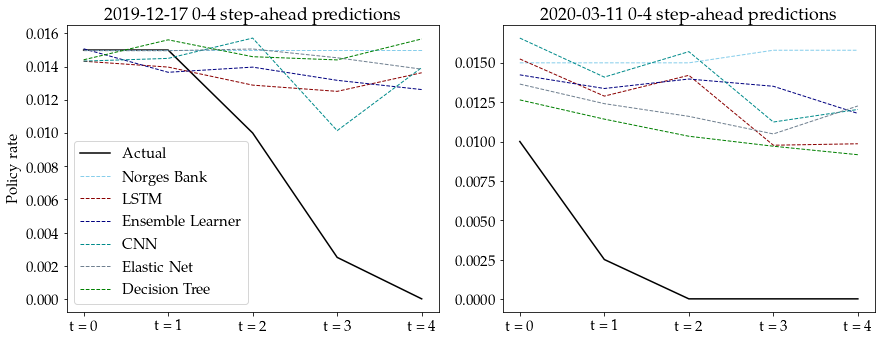

In [57]:
# === Summary of pandemic performance ===
df_2020 = df_full.loc["2020-01-01":, :]
summary_crisis = pd.DataFrame()
for n, model in enumerate(names_models):
    cols = [x for x in df_2020.columns if model in x]
    model_pred = df_2020.loc[:, cols]
    for quarter in range(len(model_pred.columns)):
        pred = model_pred.iloc[:, quarter].dropna()
        pred_index = pred.index
        summary_crisis.loc[mapping[model], "t = " + str(quarter)] = mse(folio_rates.loc[pred_index, folio_rates.columns[quarter]], pred, squared = False)

for quarter in summary_crisis.columns:
    sorted_values = summary_crisis.loc[:, quarter].sort_values()
    diff = round(np.log(sorted_values[1] / sorted_values[0]), 4)
    best_model = summary_crisis.loc[:, quarter].idxmin()
    summary_crisis.loc["Best Model", quarter] = best_model
    summary_crisis.loc["Difference", quarter] = diff

# Slice plotting dataframe
start = "2019-12-17"
dates = folio_rates.loc[start:].index[:5]
x_axis = ["t = {}".format(period) for period in range(5)]

# Extract quarterly predictions
predictions = pd.DataFrame(folio_rate.loc[dates])
for n, column in enumerate(["nb"] + names_models):
    cols = [col for col in df_copy.columns if column in col]
    predictions.loc[:, column] = df_copy.loc[start, cols].values
    
plt.figure(figsize = (12.5, 5))
plt.subplot2grid(shape = (1, 2), loc = (0, 0))
for n, fig in enumerate(predictions.columns):
    name = mapping[fig]
    plt.plot(
        x_axis,
        predictions.loc[:, fig],
        label = name,
        color = colors_models[name],
        linewidth = plotting_parameters["linewidth"][name],
        linestyle = plotting_parameters["linestyle"][name]
            )
plt.legend()
plt.ylabel("Policy rate")
plt.title("{} 0-4 step-ahead predictions".format(start))

# Slice plotting dataframe
start = "2020-03-11"
dates = folio_rates.loc[start:].index[:5]
x_axis = ["t = {}".format(period) for period in range(5)]

# Extract quarterly predictions
predictions = pd.DataFrame(folio_rate.loc[dates])
for n, column in enumerate(["nb"] + names_models):
    cols = [col for col in df_copy.columns if column in col]
    predictions.loc[:, column] = df_copy.loc[start, cols].values
    
plt.subplot2grid(shape = (1, 2), loc = (0, 1))
for n, fig in enumerate(predictions.columns):
    name = mapping[fig]
    plt.plot(
        x_axis,
        predictions.loc[:, fig],
        label = name,
        color = colors_models[name],
        linewidth = plotting_parameters["linewidth"][name],
        linestyle = plotting_parameters["linestyle"][name]
                )

plt.title("{} 0-4 step-ahead predictions".format(start))

plt.tight_layout()
    
summary_crisis
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/cov.pgf")

In [58]:
# === Descriptive statistics of models outside pandemic ===
cols = [x for x in errors.columns if x.split("_")[-1] == "1"]
df_pre_2020_q1 = errors.loc[:"2020-01-01", cols]
se_pre_2020_q1 = df_pre_2020_q1 ** 2
ae_pre_2020_q1 = abs(df_pre_2020_q1)
        
descriptive_pre_crisis = pd.DataFrame()
for model in se_pre_2020_q1.columns:
    ae = ae_pre_2020_q1.loc[:, model]
    se = se_pre_2020_q1.loc[:, model]
    rmse = np.sqrt(se.mean())
    descriptive_pre_crisis.loc[mapping["_".join(model.split("_")[:-1])], ["Max", "Min", "Median", "MAE", "RMSE"]] = [round(max(ae), 6), round(min(ae), 6), round(np.median(ae), 6), ae.mean(), rmse]

# === Descriptive statistics of models inside pandemic ===
df_2020_q1 = errors.loc["2020-01-01":, cols]
se_2020_q1 = df_2020_q1 ** 2
ae_2020_q1 = abs(df_2020_q1)
        
descriptive_crisis = pd.DataFrame()
for model in se_2020_q1.columns:
    ae = ae_2020_q1.loc[:, model]
    se = se_2020_q1.loc[:, model]
    rmse = np.sqrt(se.mean())
    descriptive_crisis.loc[mapping["_".join(model.split("_")[:-1])], ["Max", "Min", "Median", "MAE", "RMSE"]] = [round(max(ae), 6), round(min(ae), 6), round(np.median(ae), 6), ae.mean(), rmse]
    
# print(descriptive_pre_crisis)
# print("")
# print(descriptive_crisis)

print(descriptive_pre_crisis.to_latex())
print("")
print(descriptive_crisis.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       Max &       Min &    Median &       MAE &      RMSE \\
\midrule
Norges Bank      &  0.002300 &  0.000000 &  0.000100 &  0.000883 &  0.001391 \\
LSTM             &  0.003765 &  0.000006 &  0.000147 &  0.001243 &  0.001876 \\
Ensemble Learner &  0.003685 &  0.000009 &  0.000576 &  0.001365 &  0.001931 \\
CNN              &  0.003223 &  0.000056 &  0.000727 &  0.001196 &  0.001598 \\
Elastic Net      &  0.002799 &  0.000024 &  0.000410 &  0.001021 &  0.001412 \\
Decision Tree    &  0.003388 &  0.000005 &  0.000533 &  0.001145 &  0.001536 \\
\bottomrule
\end{tabular}


\begin{tabular}{lrrrrr}
\toprule
{} &       Max &       Min &    Median &       MAE &      RMSE \\
\midrule
Norges Bank      &  0.014100 &  0.005000 &  0.012500 &  0.010533 &  0.011256 \\
LSTM             &  0.010386 &  0.003845 &  0.007670 &  0.007300 &  0.007778 \\
Ensemble Learner &  0.010869 &  0.004021 &  0.008767 &  0.007886 &  0.008390 \\
CNN              &  0.011593 &  0.00

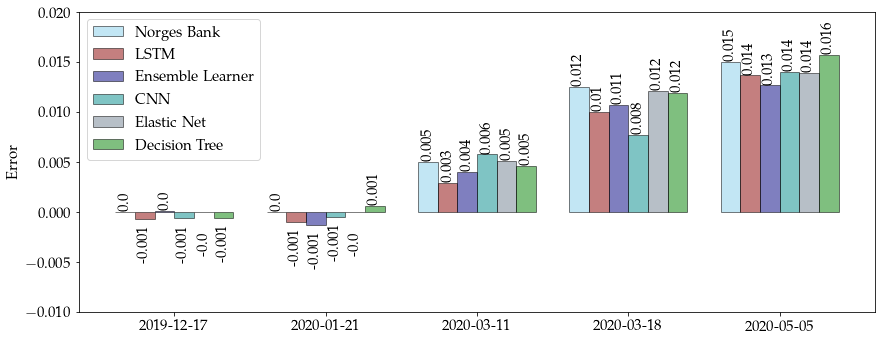

In [60]:
plt.rcParams.update({'font.size': 15})

# Slice plotting dataframe
start = "2019-12-17"
dates = folio_rates.loc[start:].index[:5]
x_axis = ["Q{}".format(period) for period in range(5)]

# Extract quarterly predictions
predictions = pd.DataFrame(folio_rate.loc[dates])
for n, column in enumerate(["nb"] + names_models):
    cols = [col for col in df_copy.columns if column in col]
    predictions.loc[:, column] = df_copy.loc[start, cols].values

temp = predictions.subtract(predictions.iloc[:, 0], axis = 0).drop(columns = "folio_rate")
mult = 1
step = [x * mult * 0.65 for x in [-0.5, -0.3, -0.1, 0.1, 0.3, 0.5]]
w = step[1] - step[0]
plt.figure(figsize = (12.5, 5))
x = np.arange(len(temp))

for n, prediction in enumerate(temp.columns):
    plt.bar(
        x + step[n],
        temp.loc[:, prediction],
        width = w,
        facecolor = colors_models[mapping[prediction]],
        edgecolor = "black",
        label = mapping[prediction],
        tick_label = temp.loc[:, prediction],
        alpha = 0.5
           )
    
    for i in range(len(temp)):
        y_ = temp.loc[temp.index[i], prediction]
        if (np.sign(y_) == 1) or (np.sign(y_) == 0):
            plt.text(x = x[i] + step[n],
                     y = temp.loc[temp.index[i], prediction] + 0.0005,
                     s = round(temp.loc[temp.index[i], prediction], 3),
                     ha = "center",
                     rotation = 90
                    )
        elif np.sign(y_) == -1:
            plt.text(x = x[i] + step[n],
                 y = temp.loc[temp.index[i], prediction] - 0.004,
                 s = round(temp.loc[temp.index[i], prediction], 3),
                 ha = "center",
                 rotation = 90  
                )

plt.xticks(ticks = x, labels = [str(x).split("T")[0] for x in temp.index.values])
plt.legend()
plt.ylabel("Error")
plt.ylim(top = 0.02, bottom = - 0.01)
plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/cov2.pgf")

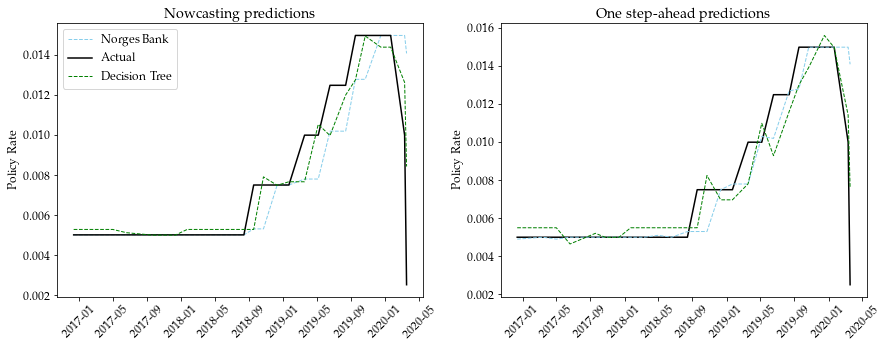

In [62]:
plt.figure(figsize = (12.5, 5))
plt.rcParams.update({'font.size': 12})

q_0 = pd.DataFrame()
for col in df.columns:
    if col == "folio_rate":
        q_0.loc[:, col] = df.loc[:, col]
    else:
        if col.split("_")[-1] == "0":
            name = "_".join(col.split("_")[:-1])
            q_0.loc[:, name] = df.loc[:, col]

plt.subplot2grid(shape = (1, 2), loc = (0, 0))
for col in q_0.columns:
    if col == "folio_rate" or col == "nb" or col == "DT":
        name = plotting_parameters["names"][col]
        plt.plot(
            q_0.loc[:, col],
            color = plotting_parameters["color"][name],
            linewidth = plotting_parameters["linewidth"][name],
            linestyle = plotting_parameters["linestyle"][name],
            label = name
        )
plt.legend()
plt.ylabel("Policy Rate")
plt.title("Nowcasting predictions")
plt.xticks(rotation = 45)

plt.subplot2grid(shape = (1, 2), loc = (0, 1))
for col in q_1.columns:
    if col == "folio_rate" or col == "nb" or col == "DT":
        name = plotting_parameters["names"][col]
        plt.plot(
            q_1.loc[:, col],
            color = plotting_parameters["color"][name],
            linewidth = plotting_parameters["linewidth"][name],
            linestyle = plotting_parameters["linestyle"][name],
            label = name,
        )
#plt.legend()
plt.ylabel("Policy Rate")
plt.title("One step-ahead predictions")
plt.xticks(rotation = 45)
plt.tight_layout()
#plt.savefig("/Users/benjaminlian/Documents/School/5th_year/Spring_2021/Master_Thesis/LaTeX/master_thesis/dt_nb.pgf")